<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/notebooks/yolo/cluster_segmented_images_using_cosine_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook assumes we have a folder of segmented images of cats.  See the notebook notebooks/yolo/extract_from_yolo_instance_segmentation_model.ipynb to see how to produce such a folder.

Given the folder of segmented images, this notebook maps the segmented images to a dense vector representation, and uses cosine similarity to tell how close two images are to one another.  This is implemented in the SentenceTransformer module.  The arbitrary parameter is the threshold above which two images will be clustered together.

In [ ]:
# image display
import IPython.display as display
from PIL import Image

# for everything else
from google.colab import drive
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import cv2

%pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util

In [2]:
# Get access to Google Drive to
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip segmented_cats.zip

In [30]:
# Path to the folder where the segmented images are stored
path_to_segmented_images = '/content/content/segmented_cats'
segmented_image_wildcard_filetype = '*.png' # File type, expressed as wildcard, of segmented images in above folder

Loading CLIP Model...
Number of images: 29


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding duplicate images...
No duplicates found.
Finding near duplicate images...
Number of non-duplicate image pairs: 406
Max score: 0.9582089781761169, min score: 0.5580941438674927
Normalizing scores...
Clustering images based on normalized similarity scores...
Number of high threshold clusters: 3
Number of low threshold clusters: 2
Number of very low threshold clusters: 7


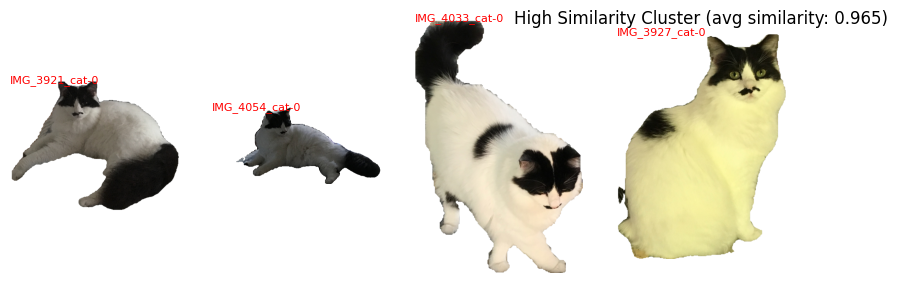

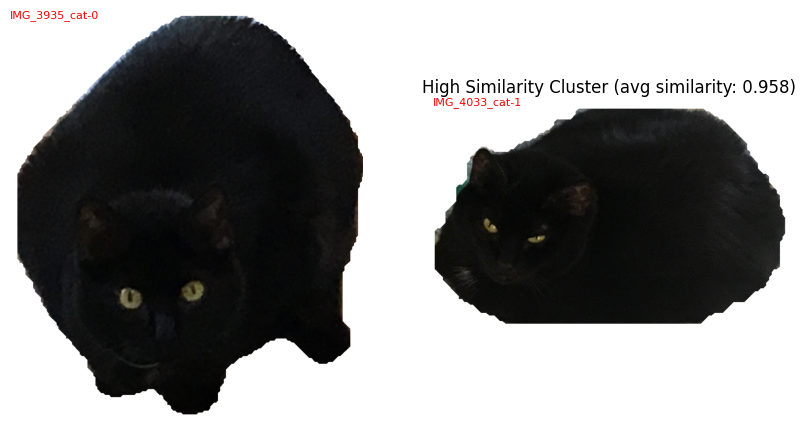

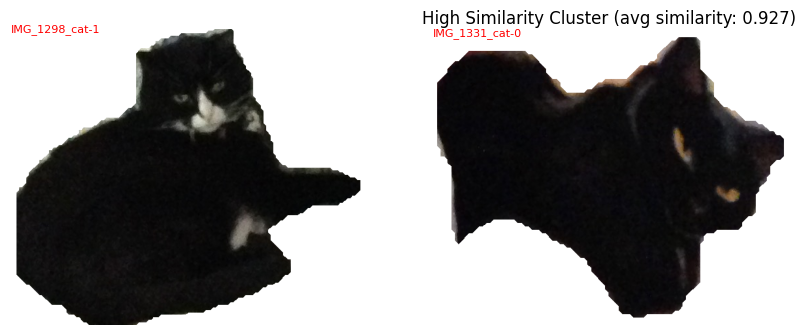

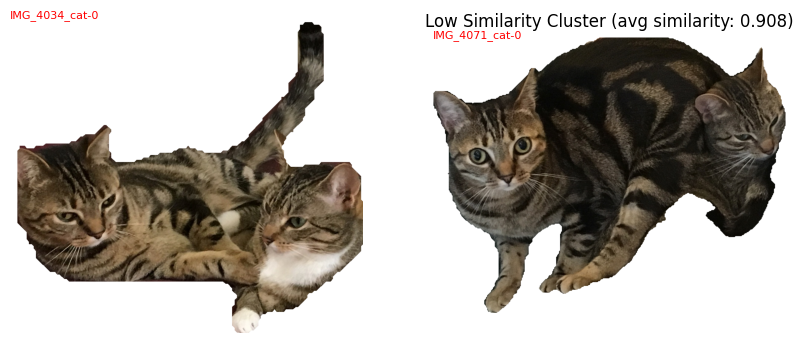

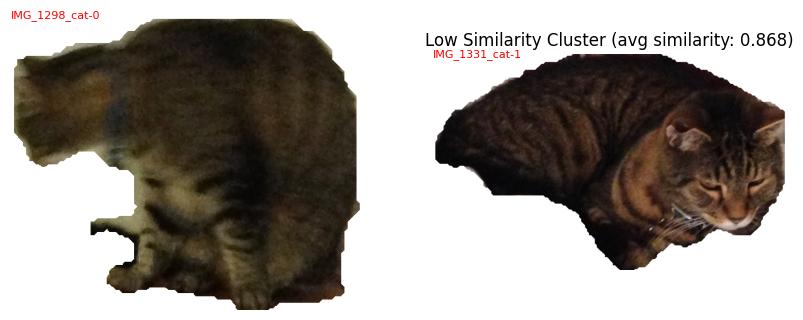

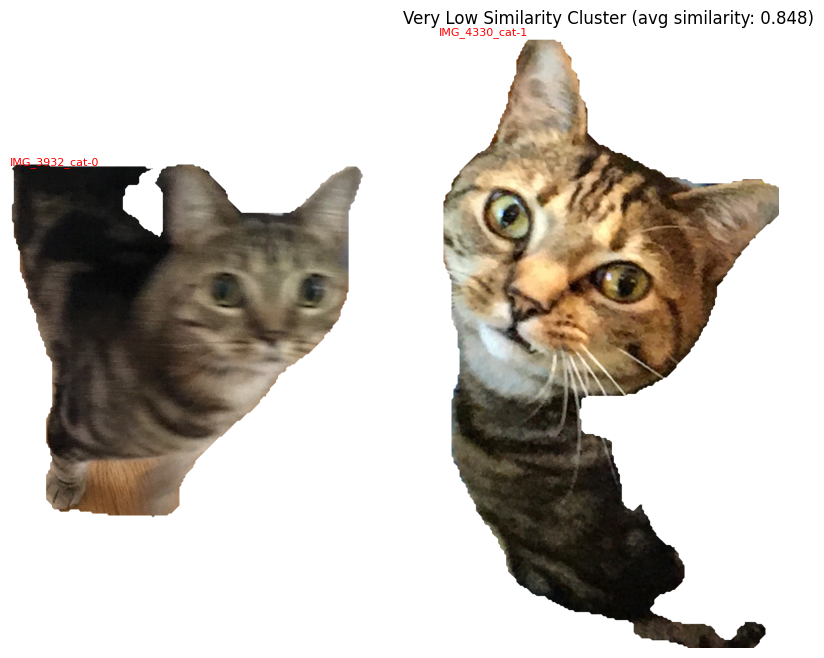

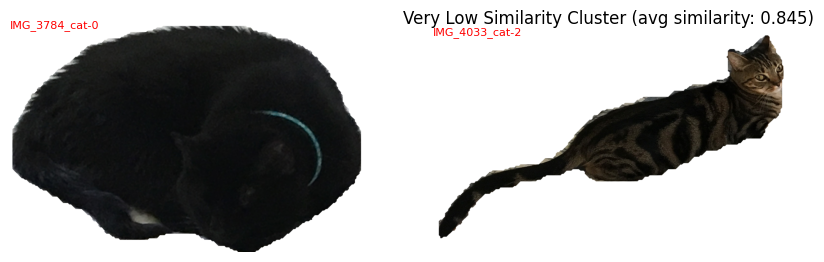

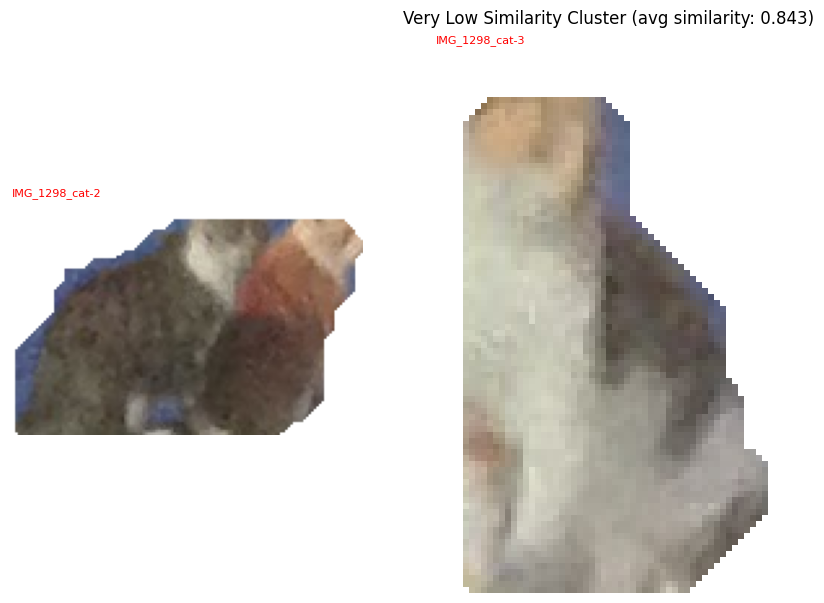

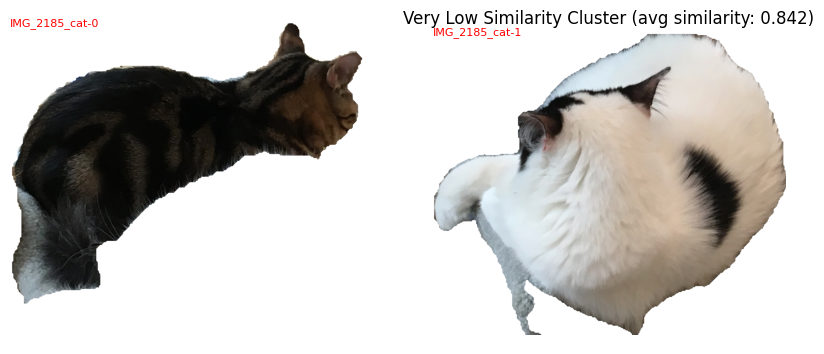

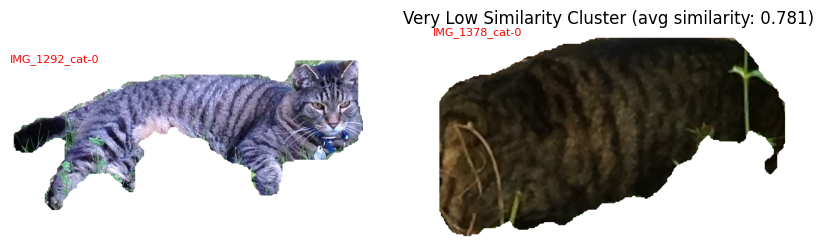

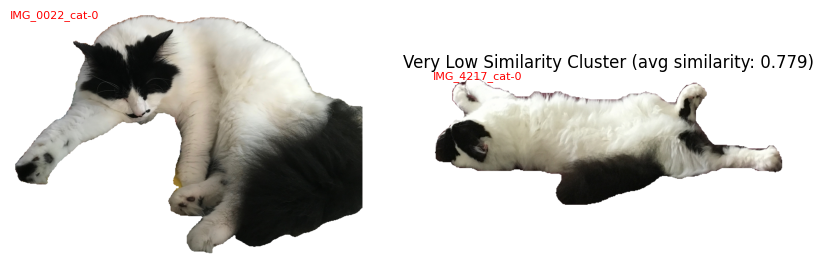

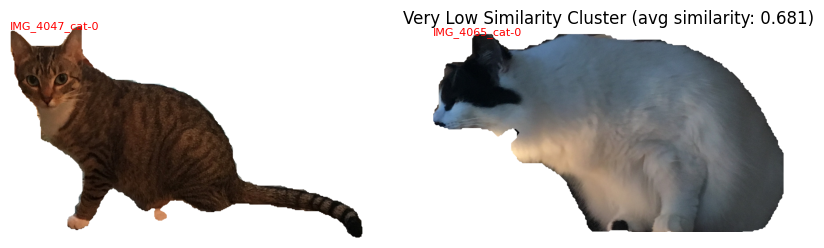

In [13]:
# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

# Next we compute the embeddings
image_names = sorted(list(glob.glob(os.path.join(path_to_segmented_images, segmented_image_wildcard_filetype))))
unclustered_image_names = image_names.copy() # used to track which images have been not yet been added to a cluster
print("Number of images: {}".format(len(image_names)))
encoded_images = model.encode([Image.open(os.path.join(path_to_segmented_images, filepath)) for filepath in image_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

# Now we run the clustering algorithm. This function compares images against
# all other images and returns a list with the pairs that have the highest
# cosine similarity score.  Each list has the similarity score followed by the
# indexes (in processed_images) of the images.
processed_images = util.paraphrase_mining_embeddings(encoded_images)

# =================
# DUPLICATES
# =================
print('Finding duplicate images...')
# Filter list for duplicates. Results are triplets (score, image_id1, image_id2) and is scorted in decreasing order.
# The two IDs are indexes into the encoded_images array.
# A duplicate image will have a score of 1.00.  It may be 0.9999 due to lossy image compression (.jpg).
duplicates = [image for image in processed_images if image[0] >= 0.999]

def show_dups(id1, id2):
  fig = plt.figure(figsize=(10,8))
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(imread(image_names[id1]))
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(imread(image_names[id2]))
  plt.axis('off')
  plt.title('Duplicates')
  plt.show()

def show_cluster(cluster, high_or_low):
  fig = plt.figure(figsize=(10,8))
  for i, image_name in enumerate(cluster[1:]): # skip the first element (the score)
    ax = fig.add_subplot(1, len(cluster) - 1, i+1)
    ax.imshow(imread(image_name))
    # Add text with desired position and formatting
    text_to_display = image_name.split('/')[-1].split('.')[0].split(' ')[-1]
    x_pos = 0.1  # Adjust for horizontal placement (0 to 1)
    y_pos = 0.8  # Adjust for vertical placement (0 to 1)
    ax.text(x_pos, y_pos, text_to_display, ha='left', va='center', fontsize=8, color='red')  # Customize font and color
    plt.axis('off')
  avg_similarity = str(round(cluster[0] / (len(cluster) - 2), 3))
  if high_or_low == 'high':
    plt.title('High Similarity Cluster (avg similarity: ' + avg_similarity + ')')
  elif high_or_low == 'low':
    plt.title('Low Similarity Cluster (avg similarity: ' + avg_similarity +')')
  else:
    plt.title('Very Low Similarity Cluster (avg similarity: ' + avg_similarity +')')
  plt.show()

# Output the top X duplicate images
if len(duplicates) > 0:
  print('Number of duplicate images: {}'.format(len(duplicates)))
  for score, image_id1, image_id2 in duplicates:
    print("\nScore: {:.3f}%".format(score * 100))
    print(image_names[image_id1])
    print(image_names[image_id2])
    show_dups(image_id1, image_id2)
else:
  print('No duplicates found.')

# =================
# NEAR DUPLICATES
# =================
print('Finding near duplicate images...')
# Use a threshold parameter to identify two images as similar. By setting the threshold lower,
# you will get larger clusters which have less similar images in it. Threshold 0 - 1.00
# A threshold of 1.00 means the two images are exactly the same. Since we are finding near
# duplicate images, we can set it at 0.99 or any number 0 < X < 1.00.
threshold = 0.99
near_duplicates = sorted([image for image in processed_images if image[0] < threshold], key=lambda x: x[0], reverse=True)
print('Number of non-duplicate image pairs: {}'.format(len(near_duplicates)))
scores_only = [image[0] for image in processed_images if image[0] < threshold]
print('Max score: {}, min score: {}'.format(max(scores_only), min(scores_only)))

# ===============
# Assemble clusters based on similarity scores
#
# Given a CLUSTER_THRESHOLD value, find all pairs of images whose similarity score is
# >= the CLUSTER_THRESHOLD.  For each image in the pair, find an array within the
# clusters array containing that image's path.  If one is found, add the other image's
# pathname to the cluster; otherwise, start a new cluster with the paths of both
# images.  When a path is added to a cluster, remove that path from the list of all
# image paths.  When all image pairs exceeding the threshold have been processed, proceed as follows
# until all paths have been removed from the list of all image paths.
#
# Continue processing pairs as above, adding new clusters and removing paths from the
# list of all paths, but with these changes:
#.    (1) Do not add any path to the clusters created from pairs exceeding the threshold
#.    (2) Do not add to a cluster any path that appears in one of the clusters whose
#         members exceed the threshold.  This may well lead to singleton clusters, and that's OK.
# ===============

HIGH_CLUSTER_THRESHOLD = 0.92
LOW_CLUSTER_THRESHOLD = 0.85
high_threshold_clusters = []
low_threshold_clusters = []
very_low_threshold_clusters = []

def normalize_scores(scores, processed_images):
    # Normalize the scores
    max_score = max(scores)
    min_score = min(scores)
    normalized_scores = []
    for image in processed_images:
        score = image[0]
        if score == max_score:
            image[0] = 1
        elif score == min_score:
            image[0] = 0
        else:
            image[0] = (score - min_score) / (max_score - min_score)

def is_high_threshold_cluster(row):
    if row[0] >= HIGH_CLUSTER_THRESHOLD:
        return True
    else:
        return False

def is_low_threshold_cluster(row):
    if row[0] < HIGH_CLUSTER_THRESHOLD and row[0] >= LOW_CLUSTER_THRESHOLD:
        return True
    else:
        return False

def is_very_low_threshold_cluster(row):
    if row[0] < LOW_CLUSTER_THRESHOLD:
        return True
    else:
        return False

def get_cluster_image_names(row):
    return [image_names[row[1]], image_names[row[2]]]

def is_one_cat_in_cluster_set(row, cluster_set):
  file1, file2 = get_cluster_image_names(row)
  for cluster in cluster_set:
    if file1 in cluster or file2 in cluster:
      return True
  return False

def remove_from_unclustered_images(files):
    for file in files:
        if file in unclustered_image_names:
            unclustered_image_names.remove(file)

def add_to_cluster(row, clusters):
    file1, file2 = get_cluster_image_names(row)
    for cluster in clusters:
        if file1 in cluster:
            if file2 not in cluster:
                cluster[0] += row[0]
                cluster.append(file2)
            return
        elif file2 in cluster:
            if file1 not in cluster:
                cluster[0] += row[0]
                cluster.append(file1)
            return
    # Didn't find file1 or file2 in any cluster, so add a new one
    # First element of every cluster is the total of similarity scores
    # for all pairs added to the cluster
    clusters.append([row[0], file1, file2])


print('Normalizing scores...')
# Normalize the scores
normalize_scores(scores_only, near_duplicates)
print('Clustering images based on normalized similarity scores...')
# Process every pair regardless of similarity score
for row in near_duplicates:
    # Continue processing until every image has been assigned to a cluster
    if len(unclustered_image_names) > 0:
        # If similarity score beats threshold, add row to a cluster in
        # the high threshold cluster list, or add a new cluster there
        if is_high_threshold_cluster(row):
          add_to_cluster(row, high_threshold_clusters)
        # If similarity score is below the high threshold, but above the low threshold,
        # add row to a low threshold cluster, but only if neither image has already
        # been assigned to a high threshold cluster
        elif not is_one_cat_in_cluster_set(row, high_threshold_clusters) and is_low_threshold_cluster(row):
          add_to_cluster(row, low_threshold_clusters)
        elif not is_one_cat_in_cluster_set(row, high_threshold_clusters) and not is_one_cat_in_cluster_set(row, low_threshold_clusters) and not is_one_cat_in_cluster_set(row, very_low_threshold_clusters) and is_very_low_threshold_cluster(row):
          add_to_cluster(row, very_low_threshold_clusters)
        # Remove file names from list of unclustered images
        file1, file2 = get_cluster_image_names(row)
        remove_from_unclustered_images([file1, file2])

    else:
        break

print('Number of high threshold clusters: {}'.format(len(high_threshold_clusters)))
print('Number of low threshold clusters: {}'.format(len(low_threshold_clusters)))
print('Number of very low threshold clusters: {}'.format(len(very_low_threshold_clusters)))

for cluster in sorted(high_threshold_clusters, key = lambda cluster: cluster[0] / (len(cluster) - 2), reverse=True):
  show_cluster(cluster, 'high')
for cluster in sorted(low_threshold_clusters, key = lambda cluster: cluster[0] / (len(cluster) - 2), reverse=True):
  show_cluster(cluster, 'low')
for cluster in sorted(very_low_threshold_clusters, key = lambda cluster: cluster[0] / (len(cluster) - 2), reverse=True):
  show_cluster(cluster, 'very low')

In [ ]:
similarities_with_filenames = [list([elt[0], image_names[elt[1]], image_names[elt[2]]]) for elt in processed_images]
similarities_with_filenames

In [33]:
path_prefix = path_to_segmented_images + '/Copy of '

def get_similarity(data, file1, file2):
  """
  This function retrieves the similarity between two files from a given list.

  Args:
      data: A list of lists, where each inner list contains [similarity, file1, file2].
      file1: The name of the first file.
      file2: The name of the second file.

  Returns:
      The similarity value between file1 and file2, or None if not found.
  """
  for item in data:
    similarity, f1, f2 = item
    if (f1 == file1 and f2 == file2) or (f1 == file2 and f2 == file1):
      return similarity
  return None


def get_similarity_of_pair(short_id1, short_id2):
  file1 = path_prefix + short_id1 + '.' + segmented_image_wildcard_filetype.split('.')[1]
  file2 = path_prefix + short_id2 + '.' + segmented_image_wildcard_filetype.split('.')[1]
  print(file1, file2)
  return get_similarity(similarities_with_filenames, file1, file2)


In [35]:
sim1 = get_similarity_of_pair('IMG_4217_cat-0', 'IMG_3921_cat-0')
sim2 = get_similarity_of_pair('IMG_4217_cat-0', 'IMG_4054_cat-0')
sim3 = get_similarity_of_pair('IMG_4217_cat-0', 'IMG_4033_cat-0')
sim4 = get_similarity_of_pair('IMG_4217_cat-0', 'IMG_3927_cat-0')
print(sim1, sim2, sim3, sim4)

/content/content/segmented_cats/Copy of IMG_4217_cat-0.png /content/content/segmented_cats/Copy of IMG_3921_cat-0.png
/content/content/segmented_cats/Copy of IMG_4217_cat-0.png /content/content/segmented_cats/Copy of IMG_4054_cat-0.png
/content/content/segmented_cats/Copy of IMG_4217_cat-0.png /content/content/segmented_cats/Copy of IMG_4033_cat-0.png
/content/content/segmented_cats/Copy of IMG_4217_cat-0.png /content/content/segmented_cats/Copy of IMG_3927_cat-0.png
0.8431279107581278 0.8510992336595702 0.7928063838513005 0.7692320641138074
